In [1]:
from pathlib import Path
import tempfile

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import umap as umap_package

In [2]:
rc = {
    # despine by default
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 100,
}
sns.set_theme(
    context="talk", style="ticks", rc=rc
)

### Helpers

In [3]:
def umap_fit_transform(X: pd.DataFrame, **kwargs) -> pd.DataFrame:
    
    # Change defaults
    kwargs["verbose"] = kwargs.get("verbose", True)
    kwargs["low_memory"] = kwargs.get("low_memory", True)

    umap_transformer = umap_package.UMAP(**kwargs)

    X_umap = umap_transformer.fit_transform(X).astype("float32")

    # return as DataFrame
    return pd.DataFrame(
        data=X_umap,
        index=X.index,
        columns=[f"UMAP_{i}" for i in range(X_umap.shape[1])],
    )

## Load data

In [4]:
swiss_df = pd.read_hdf('../data/bacterial_swissprot.h5')
swiss_df.head()

,accessions,sequence_length,sequence,description,InterPro,GO,KO,Gene3D,Pfam,KEGG,...,Superkingdom,Kingdom,Phylum,Class,Order,Family,Subfamily,Genus,Species,Transmembrane
entry_name,,,,,,,,,,,,,,,,,,,,,
12AH_CLOS4,P21215,29.0,MIFDGKVAIITGGGKAKSIGYGIAVAYAK,RecName: Full=12-alpha-hydroxysteroid dehydrog...,IPR036291,GO:0047013||GO:0030573||GO:0016042,NaN,NaN,NaN,NaN,...,Bacteria,NaN,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,NaN,Clostridium,NaN,0.0
12KD_MYCSM,P80438,24.0,MFHVLTLTYLCPLDVVXQTRPAHV,RecName: Full=12 kDa protein; Flags: Fragment;,NaN,NaN,NaN,NaN,NaN,NaN,...,Bacteria,NaN,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,NaN,Mycolicibacterium,NaN,0.0
12OLP_LISIN,Q92AT0,1086.0,MTMLKEIKKADLSAAFYPSGELAWLKLKDIMLNQVIQNPLENRLSQ...,"RecName: Full=1,2-beta-oligoglucan phosphoryla...",IPR008928||IPR012341||IPR033432,GO:0016740,K21298,1.50.10.10,PF17167,lin:lin1839,...,Bacteria,NaN,Firmicutes,Bacilli,Bacillales,Listeriaceae,NaN,Listeria,NaN,NaN
12S_PROFR,Q8GBW6||Q05617,611.0,MAENNNLKLASTMEGRVEQLAEQRQVIEAGGGERRVEKQHSQGKQT...,RecName: Full=Methylmalonyl-CoA carboxyltransf...,IPR034733||IPR000438||IPR029045||IPR011763||IP...,GO:0009317||GO:0003989||GO:0047154||GO:0006633,NaN,NaN,PF01039,NaN,...,Bacteria,NaN,Actinobacteria,Actinobacteria,Propionibacteriales,Propionibacteriaceae,NaN,Propionibacterium,NaN,0.0
14KD_MYCBO,P0A5B8||A0A1R3Y251||P30223||X2BJK6,144.0,MATTLPVQRHPRSLFPEFSELFAAFPSFAGLRPTFDTRLMRLEDEM...,RecName: Full=14 kDa antigen; AltName: Full=16...,IPR002068||IPR008978,GO:0005618||GO:0005576,NaN,2.60.40.790,PF00011,NaN,...,Bacteria,NaN,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,NaN,Mycobacterium,NaN,0.0


In [5]:
embed_df = pd.read_hdf('../data/reduced_deep_embeddings.h5')
# embed_df = pd.read_hdf('../data/reduced_3mers_embeddings.h5')
embedding_columns = embed_df.columns

embed_df.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49
entry_name,,,,,,,,,,,,,,,,,,,,,
12AH_CLOS4,-1.423302,-0.736753,-0.874685,-0.819151,-0.142118,-0.816148,0.386158,0.061937,0.687497,-0.297038,...,0.118606,-0.178684,0.080721,0.000936,-0.040333,0.036337,-0.045772,0.040853,-0.182722,0.036003
12KD_MYCSM,-2.985445,0.512436,-0.804671,-0.881089,0.023167,-0.840529,0.681208,-0.202686,0.343030,0.302511,...,0.063164,0.068167,-0.055077,0.054813,0.115826,-0.138364,-0.137902,-0.151101,-0.352669,-0.107964
12OLP_LISIN,-3.489646,0.009758,0.592749,-0.249326,-0.399583,0.004498,-0.739661,0.568125,-0.138422,-0.558067,...,0.078285,-0.139291,0.163776,-0.086977,0.097379,-0.009465,-0.043559,-0.039196,-0.102595,-0.001293
12S_PROFR,0.622390,-0.471249,0.868454,0.555548,-0.403828,-0.031662,-0.045285,-0.540816,0.314709,-0.140730,...,-0.212403,0.026798,-0.185727,-0.201333,-0.117253,-0.084229,-0.140449,-0.099275,0.174085,0.006138
14KD_MYCBO,-0.739342,0.083417,-0.164653,-0.817445,-0.376513,-0.484122,-0.727681,0.142234,0.060500,0.264555,...,-0.006761,-0.284457,0.022018,0.025971,0.017194,-0.175638,0.002390,-0.232771,-0.178814,0.032900


In [6]:
swiss_df = swiss_df.join(embed_df)

## Get EC 2.7.2 proteins

In [7]:
ec_272_pattern = "2.7.2.[\d]"
ec_272_df = supercluster_df = swiss_df.loc[
    swiss_df['EC number'].fillna('').str.match(ec_272_pattern)
]
print(supercluster_df.shape)
supercluster_df.head()

(1311, 73)


,accessions,sequence_length,sequence,description,InterPro,GO,KO,Gene3D,Pfam,KEGG,...,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49
entry_name,,,,,,,,,,,,,,,,,,,,,
ACKA1_ALIF1,Q5E6L4,398.0,MSKLVLVLNCGSSSLKFAVVDAESGAEHLTGLAECLGLPEARMKWK...,RecName: Full=Acetate kinase 1 {ECO:0000255|HA...,IPR004372||IPR000890||IPR023865,GO:0005737||GO:0008776||GO:0005524||GO:0000287...,K00925,NaN,PF00871,vfi:VF_0837,...,-0.202245,0.237319,0.274749,-0.188122,0.062177,0.029845,-0.030602,-0.001642,-0.257486,0.024281
ACKA1_CLOPE,Q8XNW5,398.0,MKILIINCGSSSLKYKLIDMANEKDIIEGIVERIGLDQSRLVQKNE...,RecName: Full=Acetate kinase 1 {ECO:0000255|HA...,IPR004372||IPR000890||IPR023865,GO:0005737||GO:0008776||GO:0005524||GO:0000287...,K00925,NaN,PF00871,cpe:CPE0217,...,-0.255378,0.270273,0.242600,-0.260075,0.004322,0.012156,-0.231694,0.003827,-0.213296,-0.062925
ACKA1_LACLA,Q9CE35,395.0,MTKTLAVNAGSSSMKWQMYEMPEEKVLAKGLIERIGLKDSIVTVKF...,RecName: Full=Acetate kinase 1 {ECO:0000255|HA...,IPR004372||IPR000890||IPR023865,GO:0005737||GO:0008776||GO:0005524||GO:0000287...,K00925,NaN,PF00871,lla:L73818,...,-0.251928,0.161746,0.249856,-0.222640,0.033795,-0.032245,-0.200179,-0.043258,-0.215033,0.040705
ACKA1_LACSS,Q9X4M1||Q38Z82,394.0,MEKILAINAGSSTLKWQLFEMPSETVIAKGMIDRLGLSDSVFTAKY...,RecName: Full=Acetate kinase 1 {ECO:0000255|HA...,IPR004372||IPR000890||IPR023865,GO:0005737||GO:0008776||GO:0005524||GO:0000287...,K00925,NaN,PF00871,lsa:LCA_0198,...,-0.205585,0.168300,0.259700,-0.148034,0.070428,0.003861,-0.192146,-0.041068,-0.241737,0.027020
ACKA1_LISIN,Q92BD4,397.0,MEKTIAINAGSSSLKFQLYDMPSERVITAGIVERIGLKDSIFTITV...,RecName: Full=Acetate kinase 1 {ECO:0000255|HA...,IPR004372||IPR000890||IPR023865,GO:0005737||GO:0008776||GO:0005524||GO:0000287...,K00925,NaN,PF00871,lin:ackA,...,-0.233359,0.192027,0.270988,-0.247302,0.053729,0.003433,-0.177058,-0.012692,-0.242866,0.024452


#### Get rid of rare pfam architectures

In [8]:
vc = ec_272_df['Pfam'].value_counts()
top_pfams = vc[vc > 3].index
ec_272_df = ec_272_df[ec_272_df['Pfam'].isin(top_pfams)]

In [9]:
ec_272_df['Pfam'].value_counts()

PF00696                      404
PF00162                      377
PF00871                      267
PF00696||PF01472             230
PF00696||PF01842||PF13840     13
PF00696||PF13840               4
PF00696||PF00742||PF03447      4
Name: Pfam, dtype: int64

In [10]:
ec_272_df = ec_272_df.query('`EC number` != "2.7.2.4||1.1.1.3"')

In [11]:
ec_272_df['EC number'].value_counts()

2.7.2.3     377
2.7.2.8     344
2.7.2.11    264
2.7.2.1     226
2.7.2.7      27
2.7.2.4      25
2.7.2.2      18
2.7.2.15     14
Name: EC number, dtype: int64

## UMAP on EC 2.7.2

In [12]:
umap_df = umap_fit_transform(ec_272_df.filter(like='pca_'), n_neighbors=15, min_dist=0.5)
umap_df.head()

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.5, verbose=True)
Construct fuzzy simplicial set
Thu Mar 24 15:28:44 2022 Finding Nearest Neighbors
Thu Mar 24 15:28:45 2022 Finished Nearest Neighbor Search
Thu Mar 24 15:28:48 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Mar 24 15:28:50 2022 Finished embedding


,UMAP_0,UMAP_1
entry_name,,
ACKA1_ALIF1,-1.355371,0.949626
ACKA1_CLOPE,-1.719129,-3.815919
ACKA1_LACLA,0.007171,-2.375933
ACKA1_LACSS,0.208198,-2.128990
ACKA1_LISIN,-0.781800,-2.553399


In [13]:
ec_272_df = ec_272_df.join(umap_df)

## Plot UMAP scatterplot

In [14]:
ec_272_df['Domains'] = ec_272_df['Pfam'].map({
    'PF00871': 'PF00871',
    'PF00696': 'PF00696',
    'PF00162': 'PF00162',
    'PF00696||PF01472': 'PF00696 and PF01472'
})
ec_272_df['Domains'] = 'Including ' + ec_272_df['Domains']

In [15]:
palette = [
    "#8d5eac",
    "#3b66b6",
    "#d3759e",
    "#2fc7bd",
    "#22967b",
    "#a22f6f",
    "#d9b063",
    "#8c6d34",
]

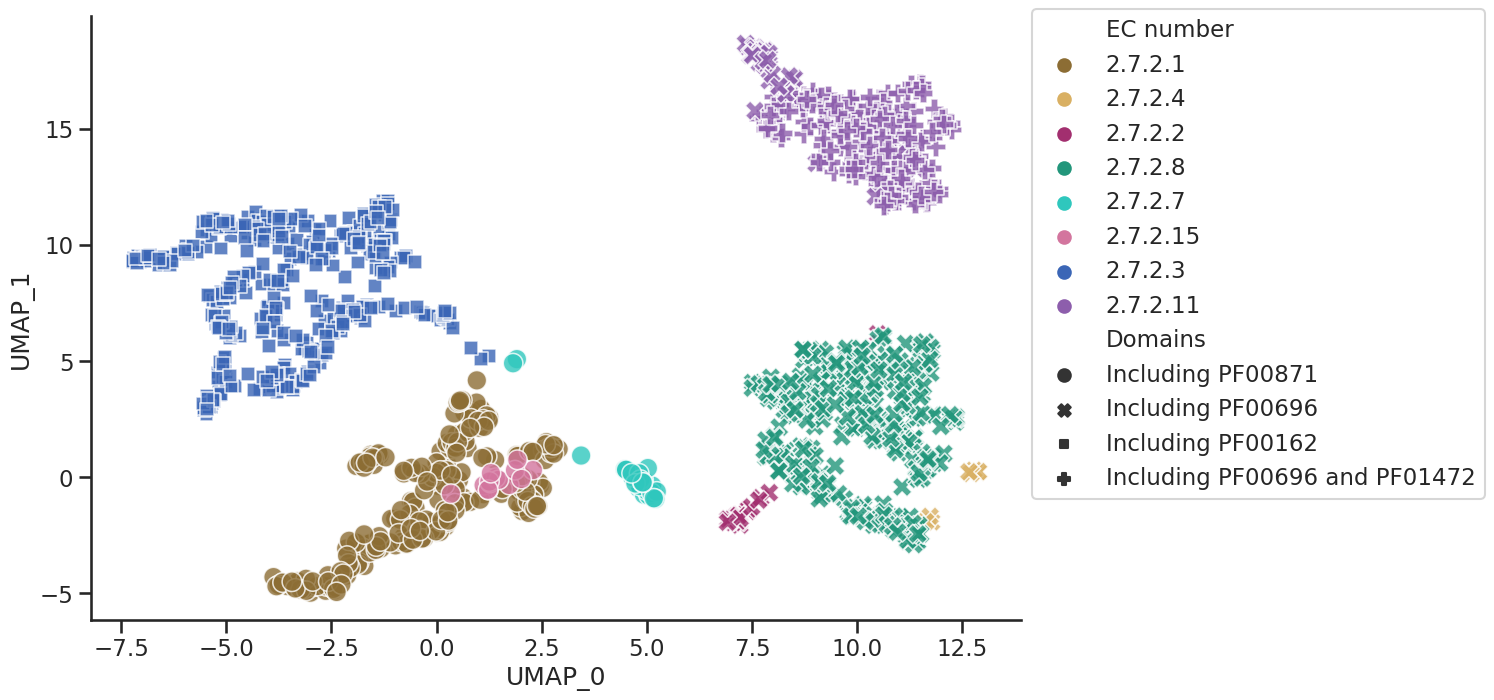

In [16]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=ec_272_df,
    x='UMAP_0',
    y='UMAP_1',
    hue='EC number',
    style='Domains',
    alpha=0.8,
    s=200,
    palette=reversed(palette)
)

plt.legend(bbox_to_anchor=(1, 1.03))

## Compare distances (Deep vs. Sequence-based)

#### Random proteins as a background

In [17]:
random_df = swiss_df.loc[swiss_df.index.difference(ec_272_df.index)].sample(500, random_state=0)
print(random_df.shape)

(500, 73)


## Generate Deep embedding based distance

In [18]:
from sklearn.metrics import euclidean_distances

def distance(df):
    return pd.DataFrame(
        data=euclidean_distances(df),
        index=df.index,
        columns=df.index
    )

def post_process(distance_matrix):    
    distance_matrix = distance_matrix.stack()
    distance_matrix.index.names = ['protein_a', 'protein_b']
    return distance_matrix

In [19]:
proteins_df = pd.concat([ec_272_df, random_df])

In [20]:
deep_distances = post_process(distance(proteins_df[embedding_columns])).to_frame('Deep')
deep_distances.head()

Deep
protein_a   protein_b            
ACKA1_ALIF1 ACKA1_ALIF1  0.000000
            ACKA1_CLOPE  0.990307
            ACKA1_LACLA  0.758275
            ACKA1_LACSS  0.800565
            ACKA1_LISIN  0.752900

## Generate sequence based distance using Clustal Omega

In [21]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [22]:
tmp_dir = Path(tempfile.mkdtemp())

sequence_file = str(tmp_dir / 'cluster.fasta')
distance_matrix = str(tmp_dir / 'distamat.txt')
clustering = str(tmp_dir / 'clustering.txt')
alignment = str(tmp_dir / 'alignment.txt')

clustalw_out = str(tmp_dir / 'clustalw.fasta')

In [23]:
SeqIO.write([
    SeqRecord(Seq(row['sequence']), id=row_id, description=row['description'])
    for row_id, row in proteins_df.iterrows()
], sequence_file, "fasta")

1795

In [24]:
# Here we are timelimiting, because we are interested only in the distance matrix.
# !sudo apt update && apt install timelimit #<- to install timelimit. 
# You can also remove timelimit from the command below and wait bit longer for all results.

!timelimit -t 1500 clustalo --infile $sequence_file \
                          --seqtype=Protein \
                          --distmat-out $distance_matrix \
                          --clustering-out=$clustering \
                          --outfile=$alignment \
                          --threads=16 \
                          --percent-id \
                          --full -v

Using 16 threads
Read 1795 sequences (type: Protein) from /tmp/tmp_b0a1maq/cluster.fasta
Calculating pairwise ktuple-distances...
Pairwise distance matrix written to /tmp/tmp_b0a1maq/distamat.txt10)
Ktuple-distance calculation progress done. CPU time: 483.79u 0.13s 00:08:03.92 Elapsed: 00:04:18
Guide-tree computation done.
^Cogressive alignment progress: 6 % (108 out of 1794)
timelimit: terminated by signal 2 during the run period


### Parse clustal results

In [25]:
clustal_dist = 100 - pd.read_csv(distance_matrix, header=None, index_col=0, skiprows=1, sep='\s+')

clustal_dist.columns = clustal_dist.index
clustal_distances = post_process(clustal_dist).to_frame('Clustal')
clustal_distances.head()

Clustal
protein_a   protein_b             
ACKA1_ALIF1 ACKA1_ALIF1   0.000000
            ACKA1_CLOPE  60.552764
            ACKA1_LACLA  60.253165
            ACKA1_LACSS  67.005076
            ACKA1_LISIN  59.949622

## Merge distances

In [26]:
distances = pd.concat([deep_distances, clustal_distances], axis=1).reset_index()
distances

,protein_a,protein_b,Deep,Clustal
0,ACKA1_ALIF1,ACKA1_ALIF1,0.000000,0.000000
1,ACKA1_ALIF1,ACKA1_CLOPE,0.990307,60.552764
2,ACKA1_ALIF1,ACKA1_LACLA,0.758275,60.253165
3,ACKA1_ALIF1,ACKA1_LACSS,0.800565,67.005076
4,ACKA1_ALIF1,ACKA1_LISIN,0.752900,59.949622
...,...,...,...,...
3222020,MSHC_MYCVP,RLMN_PROM1,3.058326,89.136490
3222021,MSHC_MYCVP,ADDA_LACCB,3.303668,86.946387
3222022,MSHC_MYCVP,RL32_BLOPB,3.396144,82.142857
3222023,MSHC_MYCVP,PRMA_NEIG1,3.212594,87.796610


In [27]:
annotations = ['EC number', 'Pfam']

In [28]:
distances = (distances
 .join(swiss_df[annotations], on='protein_a')
 .join(swiss_df[annotations], on='protein_b', rsuffix='_b')
)

### Clean EC classes (Set EC number from random proteins to "Random")

In [29]:
distances.loc[distances['protein_a'].isin(random_df.index), ['EC number', 'Pfam']] = 'Random'
distances.loc[distances['protein_b'].isin(random_df.index), ['EC number_b', 'Pfam_b']] = 'Random'
distances.head()

,protein_a,protein_b,Deep,Clustal,EC number,Pfam,EC number_b,Pfam_b
0,ACKA1_ALIF1,ACKA1_ALIF1,0.000000,0.000000,2.7.2.1,PF00871,2.7.2.1,PF00871
1,ACKA1_ALIF1,ACKA1_CLOPE,0.990307,60.552764,2.7.2.1,PF00871,2.7.2.1,PF00871
2,ACKA1_ALIF1,ACKA1_LACLA,0.758275,60.253165,2.7.2.1,PF00871,2.7.2.1,PF00871
3,ACKA1_ALIF1,ACKA1_LACSS,0.800565,67.005076,2.7.2.1,PF00871,2.7.2.1,PF00871
4,ACKA1_ALIF1,ACKA1_LISIN,0.752900,59.949622,2.7.2.1,PF00871,2.7.2.1,PF00871


### Plot Heatmap

In [30]:
order = ['2.7.2.1', '2.7.2.15', '2.7.2.7', '2.7.2.2','2.7.2.8','2.7.2.4','2.7.2.11','2.7.2.3', 'Random']
# order = ['2.7.2.1', '2.7.2.2', '2.7.2.3', '2.7.2.4','2.7.2.7','2.7.2.8','2.7.2.11','2.7.2.15', 'Random']

In [31]:
def format_annot(mean, std):
    return f'{mean:.2f}\n± {std:.2f}'

def plot_distance_heatmap(distance_df, distance_col, upper=False, cmap='Reds'):
    
    # Get distance per group
    grouped_distance = distance_df.groupby(['EC number', 'EC number_b'])[distance_col].mean()
    std = distance_df.groupby(['EC number', 'EC number_b'])[distance_col].std()
        
    annot_df = pd.concat([grouped_distance, std], axis=1).apply(lambda x: format_annot(*x), axis=1)

    plt.figure(figsize=(11,11))
    mask = np.zeros_like(grouped_distance.unstack())
    
    if upper:
        mask[np.tril_indices_from(mask, k=-1)] = True
    else:
        mask[np.triu_indices_from(mask, k=1)] = True

    sns.heatmap(
        grouped_distance.unstack().loc[order, order],
        annot=True,
    #     annot=annot_df.unstack(),
#         fmt='',
#         annot_kws=dict(fontsize=15),
        cbar=False,
        mask=mask,
        cmap=cmap,
        linewidths=1,
    )
    
#     plt.xlabel('EC number')
    plt.xlabel(None)
    plt.ylabel(None)
    
    ax = plt.gca()
    
    if upper:
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.set_label_position('right')
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        
        plt.xticks(rotation='vertical')
        plt.yticks(rotation='horizontal')
        
    return ax

In [32]:
sns.set_theme(
    context="poster", style="white", rc=rc
)

## Deep

Text(81.41666666666667, 0.5, 'Embeddings distance')

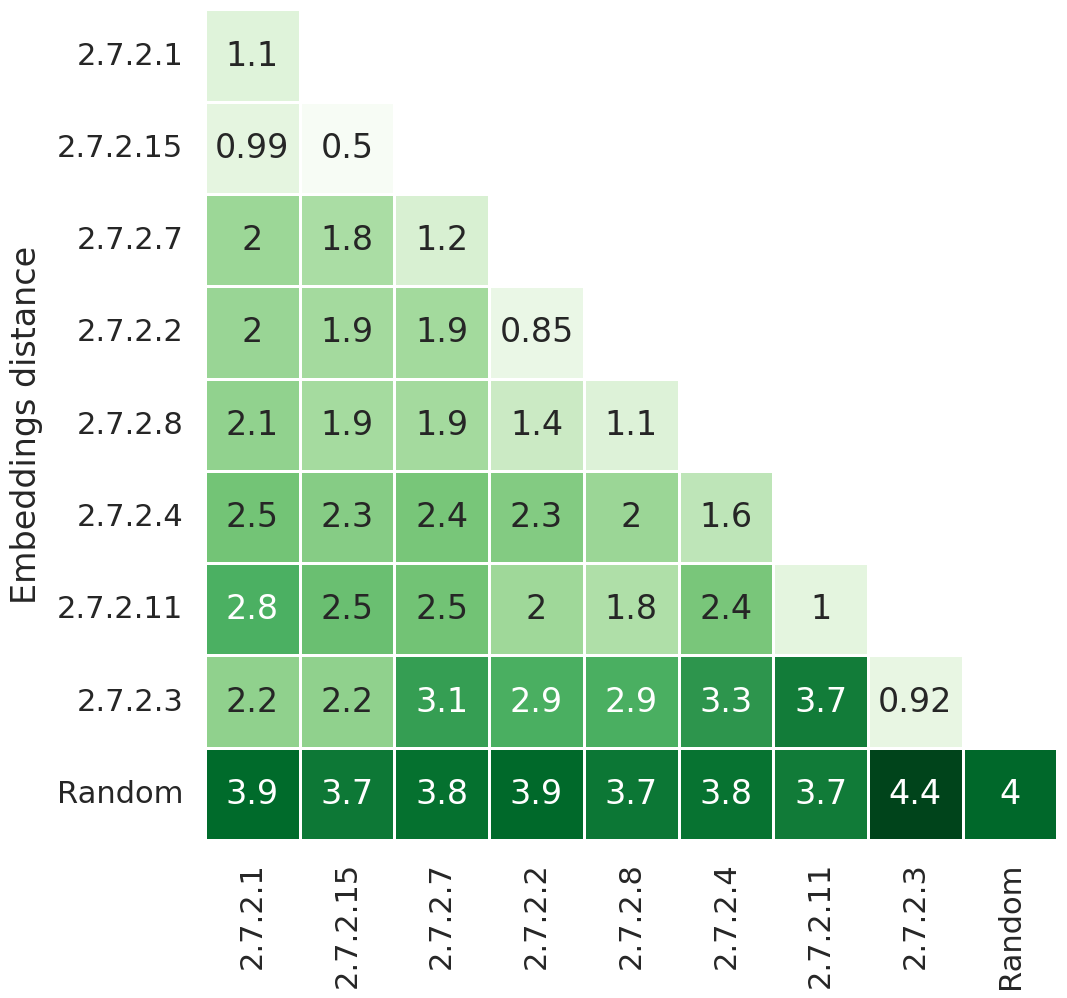

In [33]:
plot_distance_heatmap(distances, 'Deep', cmap='Greens', upper=False)
plt.ylabel('Embeddings distance', labelpad=10)

## Clustal

Text(0.5, 1.0, 'Distances between 2.7.2 groups')

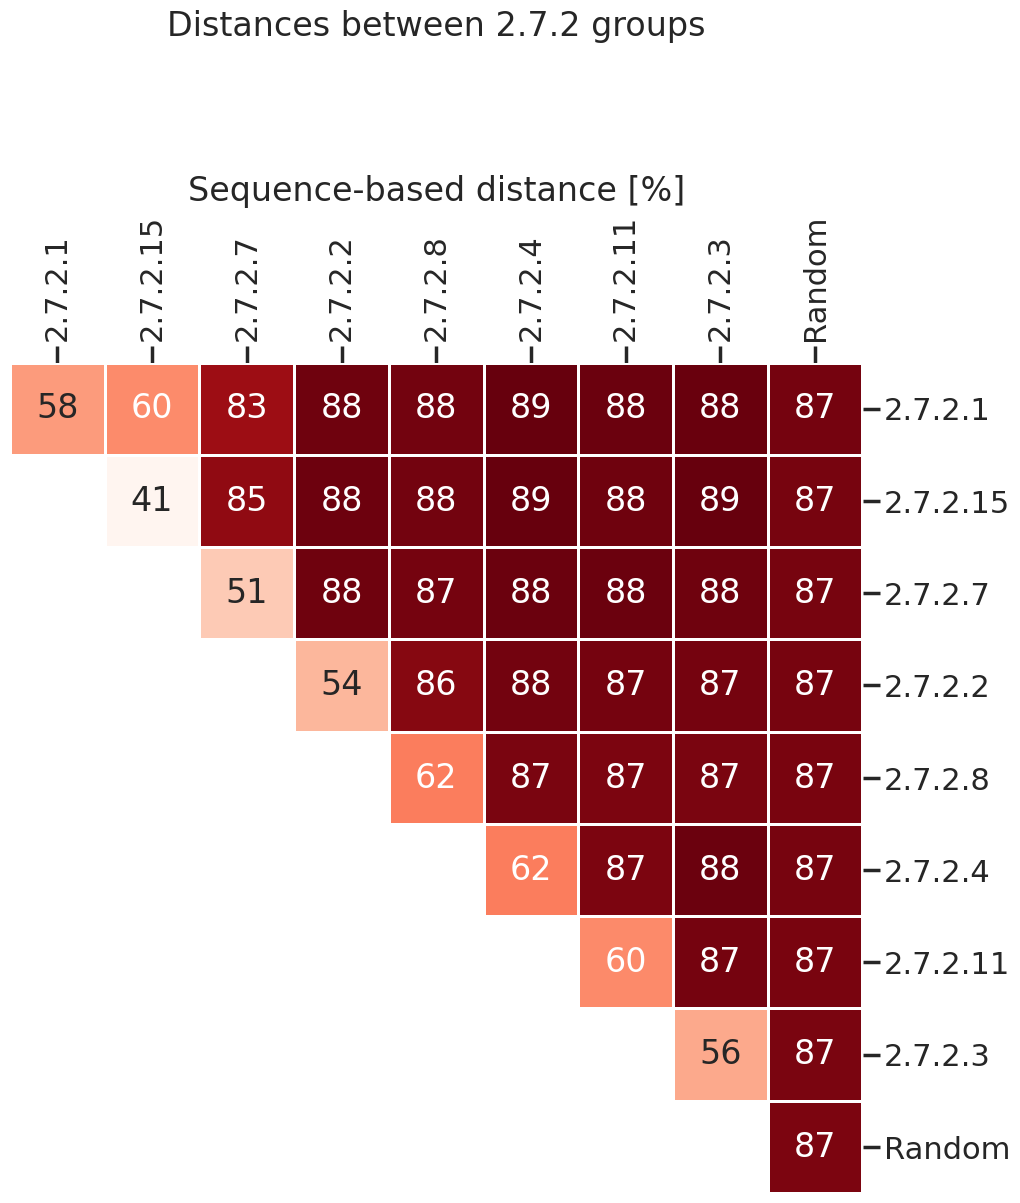

In [34]:
plot_distance_heatmap(distances, 'Clustal', upper=True)
plt.xlabel('Sequence-based distance [%]', labelpad=10)
plt.title('Distances between 2.7.2 groups', pad=100)

# Plot jointplot

In [35]:
distances['class'] = (distances['EC number'] == distances['EC number_b']).map({True:'Inside cluster', False: 'Cross cluster'})
distances.loc[(distances['EC number_b'] == 'Random'), 'class'] = 'Random'

# distances['class'] = (distances['Pfam'] == distances['Pfam_b']).map({True:'Inside cluster', False: 'Cross cluster'})
# distances.loc[(distances['Pfam_b'] == 'Random'), 'class'] = 'Random'

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1667: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(99.29166666666667, 0.5, 'Embeddings distance')

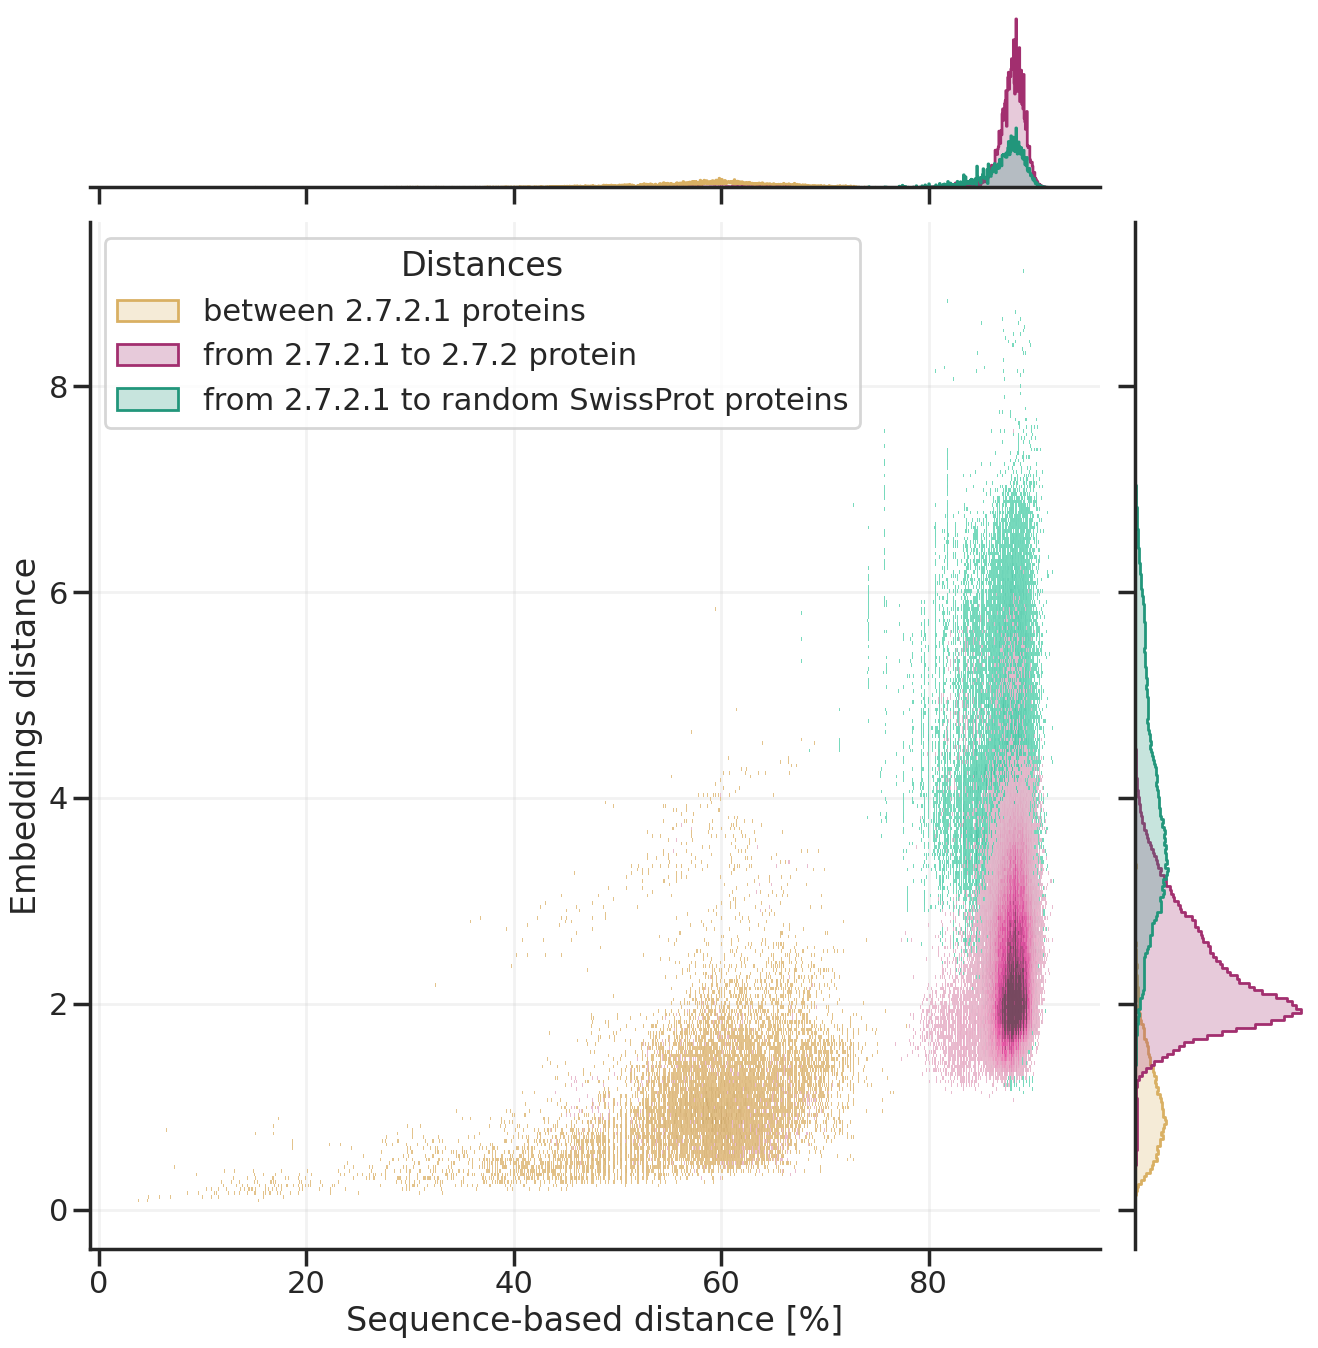

In [36]:
sns.set_theme(
    context="poster", style="ticks", rc=rc
)

g = sns.JointGrid(   
    data=distances.query('(`EC number` == "2.7.2.1") & (protein_a != protein_b)'),
    x='Clustal',
    y='Deep',
    hue='class',
    hue_order=['Random', 'Cross cluster', 'Inside cluster'],
    size=14,
    palette=palette[4:7]
)
# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(False, False), legend=False, pmax=.8, alpha=0.95,
)
g.plot_marginals(sns.histplot, element="step", stat="frequency", common_norm=False)

plt.legend(
    title='Distances',
    labels=[
        'between 2.7.2.1 proteins',
        'from 2.7.2.1 to 2.7.2 protein',
        'from 2.7.2.1 to random SwissProt proteins',
    ],
    loc='upper left',
    bbox_to_anchor=(-6, 1)
)
g.ax_joint.grid(alpha=0.25)
g.ax_joint.set_xlabel('Sequence-based distance [%]')
g.ax_joint.set_ylabel('Embeddings distance')

## List random proteins

In [37]:
from IPython.core.display import display, HTML

display(HTML(
    random_df[[
        'sequence_length', 'description',
        'GO', 'KO', 'Pfam', 'EC number',
        'Species'
    ]].to_html()
))

,sequence_length,description,GO,KO,Pfam,EC number,Species
entry_name,,,,,,,
DXR_YERP3,398.0,RecName: Full=1-deoxy-D-xylulose 5-phosphate reductoisomerase {ECO:0000255|HAMAP-Rule:MF_00183}; Short=DXP reductoisomerase {ECO:0000255|HAMAP-Rule:MF_00183}; EC=1.1.1.267 {ECO:0000255|HAMAP-Rule:MF_00183}; AltName: Full=1-deoxyxylulose-5-phosphate reductoisomerase {ECO:0000255|HAMAP-Rule:MF_00183}; AltName: Full=2-C-methyl-D-erythritol 4-phosphate synthase {ECO:0000255|HAMAP-Rule:MF_00183};,GO:0030604||GO:0046872||GO:0070402||GO:0019288||GO:0016114,K00099,PF08436||PF02670||PF13288,1.1.1.267,NaN
EFG_STRAW,709.0,RecName: Full=Elongation factor G {ECO:0000255|HAMAP-Rule:MF_00054}; Short=EF-G {ECO:0000255|HAMAP-Rule:MF_00054};,GO:0005737||GO:0005525||GO:0003924||GO:0003746,K02355,PF00679||PF03764||PF00009||PF03144,NaN,NaN
GLYA_GEOSL,415.0,RecName: Full=Serine hydroxymethyltransferase {ECO:0000255|HAMAP-Rule:MF_00051}; Short=SHMT {ECO:0000255|HAMAP-Rule:MF_00051}; Short=Serine methylase {ECO:0000255|HAMAP-Rule:MF_00051}; EC=2.1.2.1 {ECO:0000255|HAMAP-Rule:MF_00051};,GO:0005829||GO:0016597||GO:0050897||GO:0004372||GO:0030170||GO:0070905||GO:0008270||GO:1904482||GO:0046655||GO:0019264||GO:0006544||GO:0006565||GO:0006730||GO:0035999||GO:0046653,K00600,PF00464,2.1.2.1,NaN
METK_LEUMM,385.0,RecName: Full=S-adenosylmethionine synthase {ECO:0000255|HAMAP-Rule:MF_00086}; Short=AdoMet synthase {ECO:0000255|HAMAP-Rule:MF_00086}; EC=2.5.1.6 {ECO:0000255|HAMAP-Rule:MF_00086}; AltName: Full=MAT {ECO:0000255|HAMAP-Rule:MF_00086}; AltName: Full=Methionine adenosyltransferase {ECO:0000255|HAMAP-Rule:MF_00086};,GO:0005737||GO:0005524||GO:0000287||GO:0004478||GO:0006730||GO:0006556,K00789,PF02773||PF02772||PF00438,2.5.1.6,NaN
NUON_DEHMB,485.0,RecName: Full=NADH-quinone oxidoreductase subunit N {ECO:0000255|HAMAP-Rule:MF_00445}; EC=7.1.1.- {ECO:0000255|HAMAP-Rule:MF_00445}; AltName: Full=NADH dehydrogenase I subunit N {ECO:0000255|HAMAP-Rule:MF_00445}; AltName: Full=NDH-1 subunit N {ECO:0000255|HAMAP-Rule:MF_00445};,GO:0016021||GO:0005886||GO:0008137||GO:0048038||GO:0042773,K00343,PF00361,7.1.1.-,NaN
RS17_THEM4,99.0,RecName: Full=30S ribosomal protein S17 {ECO:0000255|HAMAP-Rule:MF_01345};,GO:0005840||GO:0019843||GO:0003735||GO:0006412,K02961,PF00366,NaN,NaN
SECA_DECAR,904.0,RecName: Full=Protein translocase subunit SecA {ECO:0000255|HAMAP-Rule:MF_01382};,GO:0005737||GO:0005886||GO:0005524||GO:0046872||GO:0065002||GO:0017038||GO:0006605,K03070,PF02810||PF07517||PF01043||PF07516,NaN,NaN
GLPK_DECAR,502.0,RecName: Full=Glycerol kinase {ECO:0000255|HAMAP-Rule:MF_00186}; EC=2.7.1.30 {ECO:0000255|HAMAP-Rule:MF_00186}; AltName: Full=ATP:glycerol 3-phosphotransferase {ECO:0000255|HAMAP-Rule:MF_00186}; AltName: Full=Glycerokinase {ECO:0000255|HAMAP-Rule:MF_00186}; Short=GK {ECO:0000255|HAMAP-Rule:MF_00186};,GO:0005524||GO:0004370||GO:0019563||GO:0006071||GO:0006072,K00864,PF02782||PF00370,2.7.1.30,NaN
BPT_PSEU5,235.0,RecName: Full=Aspartate/glutamate leucyltransferase {ECO:0000255|HAMAP-Rule:MF_00689}; EC=2.3.2.29 {ECO:0000255|HAMAP-Rule:MF_00689};,GO:0005737||GO:0004057||GO:0008914||GO:0071596,K21420,PF04377||PF04376,2.3.2.29,NaN
